### Program for reading e-mail data from xls file
### preparing data for embedding with openai GPT3/4
### use embedded data for training a clustering solution with sklearn
#### add colum service and offering
#### start with the request data
#### find clusters and subclusters
### intepret cluster and find most important keywords for each cluster
### optional: do a topicmodelling with berttopic
### optional: create a streamlit app to load data, amke clusters and compare them

#####  improve scipt with ideas from https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html

In [1]:
from sentence_transformers import SentenceTransformer, util,CrossEncoder

In [33]:
import pandas as pd
import os
import openai
import json
import requests
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

#from tenacity import retry, wait_random_exponential, stop_after_attempt
#from transformers import GPT2TokenizerFast
#from sklearn.datasets import fetch_20newsgroups

#### check if a openai ressource is available

In [35]:
#import os
#import json
#import openai

#openai.api_key = "3038b861bd604ead80c8e33fb53fa0c4"
#openai.api_base = "https://testnewmodel.openai.azure.com/" # your endpoint should look like the following https://YOUR_RESOURCE_NAME.openai.azure.com/
#openai.api_type = 'azure'
#openai.api_version = '2023-05-15' # this may change in the future

#deployment_name="davincinewrelease" #This will correspond to the custom name you chose for your deployment when you deployed a model. 

# Send a completion call to generate an answer
#print('Sending a test completion job')
#start_phrase = 'Write a tagline for an barber shop. '
#response = openai.Completion.create(engine=deployment_name, prompt=start_phrase, max_tokens=10)
#text = response['choices'][0]['text'].replace('\n', '').replace(' .', '.').strip()
#print(start_phrase+text)

Sending a test completion job
Write a tagline for an barber shop. A cut above the rest.


In [26]:
# Load config openai
rawconfig = open("api_keys2.json")
api_keys = json.load(rawconfig)

# set parameters
KEY_GPT3 = api_keys["GPT3_KEY"]
DEPLOY_NAME = api_keys["DEPLOYMENT_NAME"]
ENDPOINT = api_keys["ENDPOINT"]
KEY_DEEPL = api_keys["DEEPL_KEY"]

In [100]:
openai.api_key = KEY_GPT3
openai.api_base =  ENDPOINT
#openai.api_type = 'Azure OpenAI'
openai.api_type = 'azure'
#openai.api_version = '2022-06-01-preview'
openai.api_version = '2023-05-15'

#print('api_key', openai.api_key)
#print('api_base', openai.api_base)
#print('api_type', openai.api_type)
#print('api_version', openai.api_version)
#print('deploymentname', DEPLOY_NAME)

### Load Request data from xls file

In [40]:
# read data from excel file
path = r'C:\Users\MOHNC02\OneDrive - Bertelsmann SE & Co. KGaA\AirSys'

requests_data = pd.read_excel(path + '/' + 'AIRSYS_Requests.xlsx', sheet_name='AIRSYS_Requests')

requests_data 


Ticket ID    Request Type  \
0         28410  SUPPORTREQUEST   
1         28419  SUPPORTREQUEST   
2         28421  SUPPORTREQUEST   
3         30572  SUPPORTREQUEST   
4         30577  SUPPORTREQUEST   
...         ...             ...   
8429     240220  SUPPORTREQUEST   
8430     240222  SERVICEREQUEST   
8431     240224  SUPPORTREQUEST   
8432     241194  SUPPORTREQUEST   
8433     241202  SERVICEREQUEST   

                                                  Title  \
0     Request: NB23006 - Deinstallation Siemens LOGO...   
1     MSKARPIL - Bitte Software MS Visio Standard vo...   
2     MSKARPIL - Bitte Software MS Project Standard ...   
3                   Request: MindManager deinstallieren   
4     Request: Terminalservers fhhvmas2765  die Benu...   
...                                                 ...   
8429                          2x Buscontroller NTTs EOL   
8430                                     AW: SAP Antrag   
8431                           Intranet-Zugang (Portal)   
8432                           Windows Accounts löschen   
8433  Probleme Mit dem Emailverteiler und Internetzu...   

                                           Recorded by Priority  Priority No  \
0     VLehmann@ham.airport.de, VLehmann@ham.airport.de   medium            3   
1     VLehmann@ham.airport.de, VLehmann@ham.airport.de   medium            3   
2     VLehmann@ham.airport.de, VLehmann@ham.airport.de   medium            3   
3     SManthei@ham.airport.de, SManthei@ham.airport.de      low            4   
4     SSeebeck@ham.airport.de, SSeebeck@ham.airport.de   medium            3   
...                                                ...      ...          ...   
8429                                       Mols, Simon   medium            3   
8430                                       Last, Antje   medium            3   
8431                            Fricke, Marie-Christin   medium            3   
8432                                 Schwarz, Wolfgang   medium            3   
8433                                       Ley, Corvin   medium            3   

               Urgency               Source RelationType  FirstTouch  ...  \
0     slightdisruption    creationsourceess      Support           0  ...   
1     slightdisruption  creationsourceemail      Support           0  ...   
2     slightdisruption  creationsourceemail      Support           0  ...   
3         nodisruption    creationsourceess      Support           0  ...   
4     slightdisruption    creationsourceess      Support           0  ...   
...                ...                  ...          ...         ...  ...   
8429  slightdisruption  creationsourceemail      Support           0  ...   
8430  slightdisruption  creationsourceemail      Service           1  ...   
8431  slightdisruption  creationsourceemail      Support           0  ...   
8432  slightdisruption  creationsourceemail      Support           0  ...   
8433  slightdisruption  creationsourceemail      Service           1  ...   

      SLT Reso Elapsed Min SLT Reso Elapsed Hours SLT Reso Percent Used  \
0                54.603150               0.910053                   NaN   
1               113.845283               1.897421                   NaN   
2               116.290700               1.938178                   NaN   
3                77.021317               1.283689                   NaN   
4             19723.693150             328.728219                   NaN   
...                    ...                    ...                   ...   
8429             18.806533               0.313442                   NaN   
8430             19.707100               0.328452              0.164226   
8431             11.899683               0.198328                   NaN   
8432             13.926017               0.232100                   NaN   
8433              0.000000               0.000000                   NaN   

     SLT Reso Suspended StandardServiceRequest  Erstloesungsfaehig  ReOpened  \
0        

In [42]:
# prepare Request data
# rename Ticekt ID to ID and Request Type to Type
requests_data.rename(columns={'Ticket ID': 'ID', 'Request Type': 'Type'}, inplace=True)
requests_data['ID'] = 'req_' + requests_data['ID'].astype(str)
requests_data.head(3)

ID            Type  \
0  req_28410  SUPPORTREQUEST   
1  req_28419  SUPPORTREQUEST   
2  req_28421  SUPPORTREQUEST   

                                               Title  \
0  Request: NB23006 - Deinstallation Siemens LOGO...   
1  MSKARPIL - Bitte Software MS Visio Standard vo...   
2  MSKARPIL - Bitte Software MS Project Standard ...   

                                        Recorded by Priority  Priority No  \
0  VLehmann@ham.airport.de, VLehmann@ham.airport.de   medium            3   
1  VLehmann@ham.airport.de, VLehmann@ham.airport.de   medium            3   
2  VLehmann@ham.airport.de, VLehmann@ham.airport.de   medium            3   

            Urgency               Source RelationType  FirstTouch  ...  \
0  slightdisruption    creationsourceess      Support           0  ...   
1  slightdisruption  creationsourceemail      Support           0  ...   
2  slightdisruption  creationsourceemail      Support           0  ...   

   SLT Reso Elapsed Min SLT Reso Elapsed Hours SLT Reso Percent Used  \
0             54.603150               0.910053                   NaN   
1            113.845283               1.897421                   NaN   
2            116.290700               1.938178                   NaN   

  SLT Reso Suspended StandardServiceRequest  Erstloesungsfaehig  ReOpened  \
0                0.0                    NaN                 NaN       NaN   
1                0.0                    NaN                 NaN       NaN   
2                0.0                    NaN                 NaN       NaN   

  RoutedToExpertGroup Verworfen Kontingent  
0                   1      Nein         Ja  
1                   1      Nein         Ja  
2                   1      Nein         Ja  

[3 rows x 66 columns]

### incidents will be later used to create a dataframe

In [43]:
# read data from excel file
#incidents = pd.read_excel(path + '/' + 'AIRSYS_Incidents.xlsx', sheet_name='AIRSYS_Incidents')
# prepare Request data
#incidents.rename(columns={'Incident': 'ID'}, inplace=True)
#incidents['ID'] = 'inc_' + incidents['ID'].astype(str)
#incidents['Type'] = 'Incident'
#incidents

In [44]:
# concat both dataframes by appending incidents to requests
#tickets = pd.concat([requests, incidents], ignore_index=True,axis=0)
tickets = requests_data
tickets

ID            Type  \
0      req_28410  SUPPORTREQUEST   
1      req_28419  SUPPORTREQUEST   
2      req_28421  SUPPORTREQUEST   
3      req_30572  SUPPORTREQUEST   
4      req_30577  SUPPORTREQUEST   
...          ...             ...   
8429  req_240220  SUPPORTREQUEST   
8430  req_240222  SERVICEREQUEST   
8431  req_240224  SUPPORTREQUEST   
8432  req_241194  SUPPORTREQUEST   
8433  req_241202  SERVICEREQUEST   

                                                  Title  \
0     Request: NB23006 - Deinstallation Siemens LOGO...   
1     MSKARPIL - Bitte Software MS Visio Standard vo...   
2     MSKARPIL - Bitte Software MS Project Standard ...   
3                   Request: MindManager deinstallieren   
4     Request: Terminalservers fhhvmas2765  die Benu...   
...                                                 ...   
8429                          2x Buscontroller NTTs EOL   
8430                                     AW: SAP Antrag   
8431                           Intranet-Zugang (Portal)   
8432                           Windows Accounts löschen   
8433  Probleme Mit dem Emailverteiler und Internetzu...   

                                           Recorded by Priority  Priority No  \
0     VLehmann@ham.airport.de, VLehmann@ham.airport.de   medium            3   
1     VLehmann@ham.airport.de, VLehmann@ham.airport.de   medium            3   
2     VLehmann@ham.airport.de, VLehmann@ham.airport.de   medium            3   
3     SManthei@ham.airport.de, SManthei@ham.airport.de      low            4   
4     SSeebeck@ham.airport.de, SSeebeck@ham.airport.de   medium            3   
...                                                ...      ...          ...   
8429                                       Mols, Simon   medium            3   
8430                                       Last, Antje   medium            3   
8431                            Fricke, Marie-Christin   medium            3   
8432                                 Schwarz, Wolfgang   medium            3   
8433                                       Ley, Corvin   medium            3   

               Urgency               Source RelationType  FirstTouch  ...  \
0     slightdisruption    creationsourceess      Support           0  ...   
1     slightdisruption  creationsourceemail      Support           0  ...   
2     slightdisruption  creationsourceemail      Support           0  ...   
3         nodisruption    creationsourceess      Support           0  ...   
4     slightdisruption    creationsourceess      Support           0  ...   
...                ...                  ...          ...         ...  ...   
8429  slightdisruption  creationsourceemail      Support           0  ...   
8430  slightdisruption  creationsourceemail      Service           1  ...   
8431  slightdisruption  creationsourceemail      Support           0  ...   
8432  slightdisruption  creationsourceemail      Support           0  ...   
8433  slightdisruption  creationsourceemail      Service           1  ...   

      SLT Reso Elapsed Min SLT Reso Elapsed Hours SLT Reso Percent Used  \
0                54.603150               0.910053                   NaN   
1               113.845283               1.897421                   NaN   
2               116.290700               1.938178                   NaN   
3                77.021317               1.283689                   NaN   
4             19723.693150             328.728219                   NaN   
...                    ...                    ...                   ...   
8429             18.806533               0.313442                   NaN   
8430             19.707100               0.328452              0.164226   
8431             11.899683               0.198328                   NaN   
8432             13.926017               0.232100                   NaN   
8433              0.000000               0.000000                   NaN   

     SLT Reso Suspended StandardServiceRequest  Erstloesungsfaehig  ReOpened  \
0    

### Prepare data for embedding and tokenization

In [9]:
import re
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [82]:
# clean data
import openpyxl
import unicodedata
# remove non-ascii characters
tickets['Description_clean'] = tickets['Description'].astype(str).apply(openpyxl.utils.escape.unescape)
tickets['Description_clean2'] = tickets.Description_clean.apply(lambda x: (remove_html_tags(x)))
# remove unicode characters
tickets['Description_prep'] = tickets.Description_clean2.apply(lambda x: (unicodedata.normalize('NFKD', x)))

# remove non-ascii characters
tickets['Title_clean'] = tickets['Title'].astype(str).apply(openpyxl.utils.escape.unescape)
tickets['Title_clean2'] = tickets.Title_clean.apply(lambda y: (remove_html_tags(y)))
# remove unicode characters
tickets['Title_prep'] = tickets.Title_clean.apply(lambda y: (unicodedata.normalize('NFKD', y)))

In [83]:
# add services and offerings
df_news = tickets[['ID', 'Type','Title_prep','Description_prep','Solution','Timestamp_Created','Business Service','Offering']]
df_news["Target"] = tickets[['CategoryID']]
# set incident to index
#df_news.set_index('ID', inplace=True)

#df_news['Description_clean'][10000]
#teststring = df_news['Description_clean'][10000]
#print(teststring)
#result = unicodedata.normalize('NFKD', teststring)
#print(result) 
# concat GP, address and Vertrieb to one column, transform concat column into list
#df_news['concatinfo'] = df_news['Type'].astype(str) + ' || ' + df_news['Title_prep'].astype(str)  + ' || ' + df_news['Description_prep'].astype(str)

df_news['concatinfo'] = df_news['Title_prep'].astype(str)  + ' || ' + df_news['Description_prep'].astype(str) + ' || ' + df_news['Business Service'].astype(str) + ' || ' + df_news['Offering'].astype(str)
df_news['concatinfo2'] = df_news['Title_prep'].astype(str)  + ' || ' + df_news['Business Service'].astype(str) + ' || ' + df_news['Offering'].astype(str)


<Axes: >

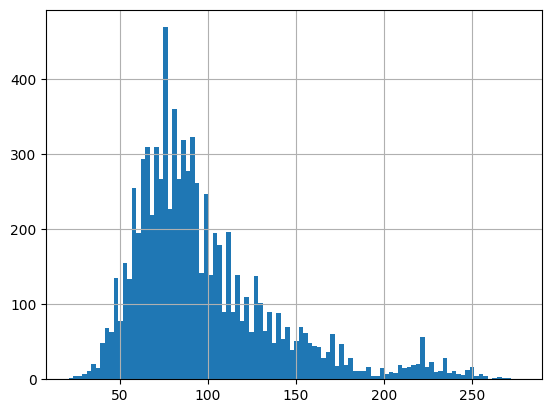

In [84]:
# check length of concat column
df_news['n_tokens'] = df_news.concatinfo2.apply(lambda x: len((x)))
#df_news['n_tokens'].hist(bins=100)
# select only tickets with less than 5000 tokens
df_news2 = df_news[df_news.n_tokens <= 6000]
df_news2['n_tokens'].hist(bins=100)
#teststring = df_news2['concatinfo'].iloc[10]
#df_news2['Description_words'] = df_news2['Description'].str.split()
#teststring = df_news2['concatinfo'].iloc[10]
#print(teststring)
#result = unicodedata.normalize('NFKD', teststring)
#print(result) 

In [85]:
# print example and create list of all tickets for embedding
print((len(df_news) - len(df_news2)), 'rows removed')
print(df_news2['concatinfo2'][5000])
#tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
# better gpt3 tokenizer
#tokenizer3 = GPT2TokenizerFast.from_pretrained("gpt2")/*?*/

# check for duplicates in df_news2
df_news2.drop_duplicates(subset=['ID'], inplace=True)
print(df_news2.shape)

#Our sentences we like to encode
corpus = df_news2['concatinfo2'].values.tolist()

0 rows removed
WG: SAP Antrag || LS049 SAP ERP (PFH) Produktion [107217] || nan
(8329, 12)


### send data to openai/sentence transformer for embedding

In [86]:
#model = SentenceTransformer('distilbert-base-nli-mean-tokens')
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(corpus, show_progress_bar=True)

Batches:   0%|          | 0/261 [00:00<?, ?it/s]

In [87]:
## save embedding to pickle file
# Store sentences & embeddings on disc
import pickle
picklename = "service_email_analysis_3comnp.pkl"
with open(picklename, "wb") as fOut:
    pickle.dump({'embeddings': embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [76]:
# laod pickled embeddings
# read embeddings
#def readembedding(picklename = 'embeddings.pkl'):
#    ''' load pickled embedding and prepare for similiarity measure'''
#    #Load sentences & embeddings from disc
#    with open(picklename, "rb") as fIn:
#        stored_data = pickle.load(fIn)
#        #stored_sentences = stored_data['sentences']
#        stored_embeddings = stored_data['embeddings']
    
#    return stored_embeddings

In [77]:
#stored_embeddings = readembedding(picklename = picklename)

### train clustering solution with sklearn, tim identified some clusters , so we will take his solution as a baseline
### send cluster results to openai for interpretation

In [88]:
# two optimal cluster k=7 and k=71
k = 7
#clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5) #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model_opt = KMeans(n_clusters=k, random_state=42)
clustering_model_opt.fit(embeddings)
cluster_assignment_opt = clustering_model_opt.labels_
#cluster_distances_opt = clustering_model_opt.inertia_.tolist()

# create new dataframe with assigned cluster info
cust_ids = df_news2['ID'].to_list()
df_clusters_opt = pd.DataFrame(list(zip(cust_ids, cluster_assignment_opt)), columns=['ID','Cluster'])
df_news_opt = df_news2.merge(df_clusters_opt, how='inner', on='ID')
df_news_opt.drop_duplicates(subset=['ID'], inplace=True)
df_news_opt['Cluster'].value_counts()

Cluster
2    2627
3    2157
1    1090
5     909
0     602
4     500
6     444
Name: count, dtype: int64

In [57]:
df_news_opt

ID            Type  \
0      req_28410  SUPPORTREQUEST   
1      req_28419  SUPPORTREQUEST   
2      req_28421  SUPPORTREQUEST   
3      req_30572  SUPPORTREQUEST   
4      req_30577  SUPPORTREQUEST   
...          ...             ...   
8299  req_240220  SUPPORTREQUEST   
8300  req_240222  SERVICEREQUEST   
8301  req_240224  SUPPORTREQUEST   
8302  req_241194  SUPPORTREQUEST   
8303  req_241202  SERVICEREQUEST   

                                             Title_prep  \
0     Request: NB23006 - Deinstallation Siemens LOGO...   
1     MSKARPIL - Bitte Software MS Visio Standard vo...   
2     MSKARPIL - Bitte Software MS Project Standard ...   
3                   Request: MindManager deinstallieren   
4     Request: Terminalservers fhhvmas2765  die Benu...   
...                                                 ...   
8299                          2x Buscontroller NTTs EOL   
8300                                     AW: SAP Antrag   
8301                           Intranet-Zugang (Portal)   
8302                          Windows Accounts löschen   
8303  Probleme Mit dem Emailverteiler und Internetzu...   

                                       Description_prep  \
0               die Software wird nicht mehr benötigt.   
1     \r\n Hallo Hotline-Team,\r\n &nbsp;\r\n die So...   
2     \r\n Hallo Hotline-Team,\r\n &nbsp;\r\n die So...   
3     Bitte den MindManager auf dem Laptop NB23105 d...   
4     Bezüglich des Terminalservers fhhvmas2765 hat...   
...                                                 ...   
8299  Moin zusammen,könnte ihr bitte hierfür ein T...   
8300  \r\n Hallo Service- Team,\r\n  \r\n wie telefo...   
8301  \r\n Guten Tag,\r\n &nbsp;\r\n für den neuen ...   
8302  \r\n &nbsp;\r\n Moin AIRSYS-Team,\r\n &nbsp;\r...   
8303  \r\n Sehr geehrte Damen und Herren,\r\n &nbsp;...   

                                               Solution  \
0                           Deinstallation durchgeführt   
1     Software-Deinstallation eingereiht&nbsp;&amp; ...   
2     Software-Deinstallation eingereiht&nbsp;&amp; ...   
3     Deinstallation via Baramundi zugewiesen. Deins...   
4     GPO für 2765 erstellt / RDP Sitzung wird 1 min...   
...                                                 ...   
8299                                                NaN   
8300                                                NaN   
8301                                                NaN   
8302                                                NaN   
8303                                                NaN   

            Timestamp_Created  \
0     2022-09-05 12:41:42.000   
1     2022-09-06 06:03:10.000   
2     2022-09-06 06:03:10.000   
3     2022-09-05 11:41:21.000   
4     2022-09-05 15:02:16.000   
...                       ...   
8299  2023-06-20 11:09:11.000   
8300  2023-06-20 13:04:11.000   
8301  2023-06-20 13:16:06.000   
8302  2023-06-20 10:14:04.000   
8303  2023-06-20 12:54:11.000   

                                     Business Service  \
0                     Softwareinstallation Produktion   
1                     Softwareinstallation Produktion   
2                     Softwareinstallation Produktion   
3                                  Mindjet Produktion   
4         LS064 Terminal Services Produktion [107217]   
...                                               ...   
8299                 NTT (Nottuerterminal) Produktion   
8300          LS049 SAP ERP (PFH) Produktion [107217]   
8301                                  Jira Produktion   
8302  LS001 AD - Active Directory Produktion [107217]   
8303  LS001 AD - Active Directory Produktion [107217]   

                                               Offering  Target  \
0                                               Request   28661   
1                                                   NaN   28043   
2                                                   NaN   28043   
3                                               Request   28661   
4                                    

<Axes: title={'center': 'Cluster distribution'}, xlabel='Cluster'>

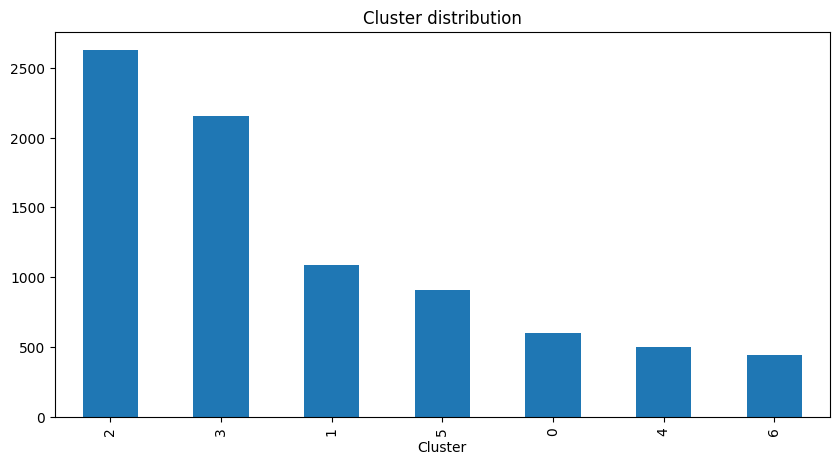

In [89]:
df_news_opt['Cluster'].value_counts().plot(kind='bar', figsize=(10,5), title='Cluster distribution')

In [90]:
df_news_opt.shape

(8329, 13)

In [60]:
# select only news with n_tokens less than 500 
df_news_opt2 = df_news_opt[df_news_opt.n_tokens <= 2000]

#drop cluster with size less than 10
#df_news_opt2 = df_news_opt2.groupby('Cluster').filter(lambda x : len(x)>10)

In [61]:
# histogram of cluster sizes
df_news_opt2.groupby('Cluster')['ID'].count()

Cluster
0    1805
1    1804
2     989
3    1066
4     637
5     441
6     109
Name: ID, dtype: int64

In [87]:
# change cluster number 6 to number 2
#df_news_opt2['Cluster'] = df_news_opt2['Cluster'].replace(6,2)
#df_news_opt2.groupby('Cluster')['ID'].count()

### call openai for topic modelling


In [91]:
#import openai

# Reading a review which belong to each group.
rev_per_cluster = 4
#k = 6
for i in range(k):
    print(f"Cluster {i} Thema:", end=" ")

    reviews = "\n".join(
        df_news_opt2[df_news_opt2.Cluster == i]
        .concatinfo
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine=DEPLOY_NAME,
        prompt=f'Was haben die folgenden E-Mail Nachrichten gemeinsam?\n\nNachricht:\n"""\n{reviews}\n"""\n\nThema:',
        temperature=0,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    #sample_cluster_rows = df_news_opt2[df_news_opt2.Cluster == i].sample(rev_per_cluster, random_state=42)
    #for j in range(rev_per_cluster):
        #print(sample_cluster_rows.Score.values[j], end=", ")
        #print(sample_cluster_rows.Summary.values[j], end=":   ")
        #print(sample_cluster_rows.concatinfo.str[:100].values[j])

    #print("-" * 100)

Cluster 0 Thema:  nanRechnernummer: DB21045Telefonnummer: +494050753938Betreff: WARNUNG::PDA (Bädker, Kurt) Passcode nicht konform
Cluster 1 Thema:  Superoffice Daten / Geburtstagslisten wegNachricht: Sehr geehrte Damen und Herren,im Superoffice fehlen mir die Geburtstagslisten, die von Frau Karen Stein angelegt worden sind. Diese benötigen wir dringend, da unser Bereich jeden Monat Karten verschickt. Ich weiß leider nicht, welche Personen in diesen Listen standen und bitte Sie die Daten schnellstmöglich wieder herzustellen. Wir benötigen die Personen und Adressen für April.Mit freundlichen GrüßenShari-Michelle NoßAssistenz Kommunikation, Politik und UmweltFlughafen Hamburg GmbH Flughafenstraße 1-3 D-22335 HamburgTel.: +49 40 5075-3611 E-Mail: snoss@ham.airport.de www.hamburg-airport.
Cluster 2 Thema:  RequestAlle drei Nachrichten enthalten eine Bitte um etwas. In der ersten Nachricht wird um die Bereitstellung eines ADIL-Kontrollzentrums gebeten, in der zweiten Nachricht wird um

In [44]:
## grapical representation of clusters
#from sklearn.manifold import TSNE
#import matplotlib
#import matplotlib.pyplot as plt

#matrix = np.vstack(embeddings.values)
#matrix.shape

In [92]:
embeddings.shape

(8329, 384)

In [93]:
category = list(range(0, 7))
print(category)

[0, 1, 2, 3, 4, 5, 6]


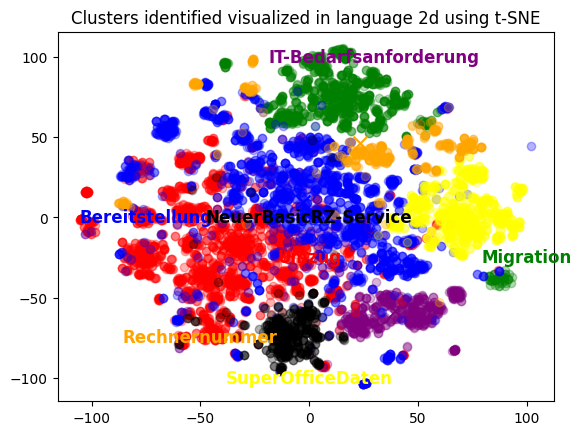

In [94]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(embeddings)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

#customPalette = ['#630C3A', '#39C8C6', '#D3500C', '#FFB139','#']
customPalette = ["purple", "green", "red", "blue",'black','yellow','orange']

#define labels and where they should go
labelcoord = {'IT-Bedarfsanforderung': (30,100),
          'Migration': (100,-25),
          'Umzug': (0,-25),
          'Bereitstellung': (-75,0),
          'NeuerBasicRZ-Service': (0,0),
          'SuperOfficeDaten': (0,-100),
          'Rechnernummer': (-50,-75)}
labels = ['IT-Bedarfsanforderung','Migration','Umzug','Bereitstellung','NeuerBasicRZ-Service','SuperOfficeDaten','Rechnernummer']
colors = ["purple", "green", "red", "blue",'black','yellow','orange']

categories = list(range(0, 7))
#print(category)

for (category, color,label) in zip(categories, colors, labels):
    xs = np.array(x)[df_news_opt.Cluster == category]
    ys = np.array(y)[df_news_opt.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
    
    #add label
    plt.annotate(label,
                 labelcoord[label],
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=12, weight='bold',
                 color=customPalette[category]) 
    
plt.title("Clusters identified visualized in language 2d using t-SNE")
plt.show()

### Results so far: Cluster solution is not good enough. Using the embeddings to generate topics with berttopic.

In [68]:
from bertopic import BERTopic

C:\Users\MOHNC02\AppData\Roaming\Python\Python311\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\MOHNC02\AppData\Roaming\Python\Python311\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\MOHNC02\AppData\Roaming\Python\Python311\site-packages\umap\d

#### prepare data for topic modeling

In [95]:
# one output for all email issues
#df_news_slice = df_news_opt[df_news_opt.Cluster == cluster]
docs = df_news_opt['concatinfo2']
bodel = BERTopic(language="german", verbose=True)
topics, probabilities = bodel.fit_transform(docs)
resall = bodel.get_topic_info()
# result to excel
resall.to_excel(path + '/' + 'AIRSYS_TopicsV2_short'  + '.xlsx', sheet_name='AIRSYS_Topics_short')

Batches:   0%|          | 0/261 [00:00<?, ?it/s]

2023-08-21 19:23:58,272 - BERTopic - Transformed documents to Embeddings
2023-08-21 19:24:05,999 - BERTopic - Reduced dimensionality
2023-08-21 19:24:06,271 - BERTopic - Clustered reduced embeddings


In [96]:
resall

Topic  Count                                               Name  \
0       -1   1633              -1_softwareinstallation_request_wg_aw   
1        0    174                   0_bedarfsanforderung_an_it_ls001   
2        1    155                           1_netzwerk_wlan_lan_vlan   
3        2    143                                2_pfh_ls049_sap_erp   
4        3    124                       3_idrop_automaten_sbd_server   
..     ...    ...                                                ...   
200    199     11                 199_ssr016_systeme_updates_patches   
201    200     11                       200_scanner_inop_vier_wachen   
202    201     11                   201_pc_abholen_tastatur_abmelden   
203    202     10                       202_office_365_slomas_iconen   
204    203     10  203_telefonnummern_telefon_liste_telekommunika...   

                                        Representation  \
0    [softwareinstallation, request, wg, aw, nan, a...   
1    [bedarfsanforderung, an, it, ls001, directory,...   
2    [netzwerk, wlan, lan, vlan, internetverbindung...   
3    [pfh, ls049, sap, erp, mandant, 002, tfh, syst...   
4    [idrop, automaten, sbd, server, und, fehlermel...   
..                                                 ...   
200  [ssr016, systeme, updates, patches, installati...   
201  [scanner, inop, vier, wachen, ausall, sieht, s...   
202  [pc, abholen, tastatur, abmelden, rechner, har...   
203  [office, 365, slomas, iconen, softwareinstalla...   
204  [telefonnummern, telefon, liste, telekommunika...   

                                   Representative_Docs  
0    [SSR022 - Non-AD User Einrichten, Ändern, Spe...  
1    [IT-Ticket || LS001 AD - Active Directory Prod...  
2    [Keine Netzwerk Verbindung || Netzwerk Produkt...  
3    [SAP-User || LS049 SAP ERP (PFH) Produktion [1...  
4    [Test || iDrop Server und Automaten Produktion...  
..                                                 ...  
200  [SSR016 - Installation von Patches und Updates...  
201  [drei Scanner inop || Hardware / Sonstiges Pro...  
202  [Umbau PC Landschaft FP-PG Gepäckleitstand ||...  
203  [SLOMAS nicht als APP mehr installiert || Soft...  
204  [WG: Liste der Telefonnummern || Telefon (Tele...  

[205 rows x 5 columns]

#### Fine-tune Topic Representations

In [97]:
from bertopic.representation import KeyBERTInspired

# Fine-tune your topic representations
representation_model = KeyBERTInspired()
topic_model2 = BERTopic(representation_model=representation_model)

#bodel = BERTopic(language="german", verbose=True)
topics2, probabilities2 = topic_model2.fit_transform(docs)
resfine = topic_model2.get_topic_info()
# result to excel
resfine.to_excel(path + '/' + 'AIRSYS_TopicsFineV3'  + '.xlsx', sheet_name='AIRSYS_TopicsFineV3')


2023-08-21 19:25:08,355 - BERTopic - Transformed documents to Embeddings
2023-08-21 19:25:15,611 - BERTopic - Reduced dimensionality
2023-08-21 19:25:15,876 - BERTopic - Clustered reduced embeddings


In [99]:
from bertopic.representation import ZeroShotClassification
#from bertopic import BERTopic

# Create your representation model
candidate_topics = ["sap", "netzwerk", "mail", "hardware", "software", "Berechtigungen"]
representation_model = ZeroShotClassification(candidate_topics, model="facebook/bart-large-mnli")

# Use the representation model in BERTopic on top of the default pipeline
topic_model3 = BERTopic(representation_model=representation_model)


#bodel = BERTopic(language="german", verbose=True)
topics3, probabilities3 = topic_model3.fit_transform(docs)
resclass = topic_model3.get_topic_info()
# result to excel
resclass.to_excel(path + '/' + 'AIRSYS_TopicsClass'  + '.xlsx', sheet_name='AIRSYS_TopicsClass')


2023-08-22 11:40:54,827 - BERTopic - Transformed documents to Embeddings
2023-08-22 11:41:02,556 - BERTopic - Reduced dimensionality
2023-08-22 11:41:02,829 - BERTopic - Clustered reduced embeddings


In [98]:
topic_model2.visualize_hierarchy()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.12847129, 0.12847129, 0.        ]),
              'xaxis': 'x',
              'y': array([-25., -25., -35., -35.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.28375594, 0.28375594, 0.12847129]),
              'xaxis': 'x',
              'y': array([-15., -15., -30., -30.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.30695984, 0.30695984, 0.        ]),
              'xaxis': 'x',
              'y': array([-55., -55., -65., -65.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.33785271, 0.33785271, 0.30695984]),
              'xaxis': 'x',
              'y': array([-45., -45., -60., -60.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.15887564, 0.15887564, 0.        ]),
              'xaxis': 'x',
              'y': array([-85., -85., -95., -95.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.19726901, 0.19726901, 0.15887564]),
              'xaxis': 'x',
              'y': array([-75., -75., -90., -90.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.33785271, 0.4334129 , 0.4334129 , 0.19726901]),
              'xaxis': 'x',
              'y': array([-52.5, -52.5, -82.5, -82.5]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.28375594, 0.50133768, 0.50133768, 0.4334129 ]),
              'xaxis': 'x',
              'y': array([-22.5, -22.5, -67.5, -67.5]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.60286292, 0.60286292, 0.50133768]),
              'xaxis': 'x',
              'y': array([ -5.,  -5., -45., -45.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.44371563, 0.44371563, 0.        ]),
              'xaxis': 'x',
              'y': array([-105., -105., -115., -115.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.27860846, 0.27860846, 0.        ]),
              'xaxis': 'x',
              'y': array([-125., -125., -135., -135.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.27860846, 0.43709336, 0.43709336, 0.        ]),
              'xaxis': 'x',
   

#### better results with berttopic, to improve solution: reduce outliers, merge topics, create a hierarchy of topics

In [101]:
topic_model2.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'produktion | nan | vertretungsregelung | storung | onprem', 219],
                                   [1,
                                    'outlookanmeldung | outlook | outlookversand | outlookproblem | produktion',
                                    217],
                                   [2, 'produktion | idrop | automaten | server | sbd', 126],
                                   ...,
                                   [193, 'vpn | vpnclient | tunnel | ls063 | request', 11],
                                   [194, 'teammanager | produktion | team | manager | tm3', 11],
                                   [195, 'monitor | produktion | nan | hardware | tobt', 11]], dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customdata[1]}<br>Size: %{customdata[2]}',
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': array([219, 217, 126, 126, 120, 115, 104, 103,  95,  91,  87,  87,  86,  85,
                                         85,  82,  73,  73,  72,  72,  71,  70,  70,  67,  66,  64,  63,  61,
                                         60,  57,  57,  56,  56,  56,  55,  55,  55,  54,  53,  52,  49,  47,
                                         47,  45,  44,  43,  43,  42,  41,  41,  40,  40,  39,  38,  38,  37,
                                         36,  36,  36,  34,  34,  33,  33,  33,  33,  32,  32,  32,  32,  31,
                                         31,  31,  31,  30,  30,  30,  30,  30,  30,  29,  29,  29,  29,  29,
                                         29,  28,  28,  28,  28,  27,  27,  27,  27,  27,  26,  26,  26,  26,
                                         26,  26,  25,  25,  25,  25,  24,  24,  24,  24,  24,  24,  24,  23,
                                         23,  23,  23,  22,  22,  22,  22,  22,  21,  21,  21,  21,  21,  21,
                                         20,  20,  20,  20,  19,  19,  19,  19,  19,  19,  19,  18,  18,  18,
                                         18,  18,  18,  17,  17,  17,  17,  17,  17,  17,  16,  16,  16,  16,
                                         16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  15,  15,  15,  15,
                                         15,  15,  15,  15,  15,  14,  14,  14,  14,  14,  14,  13,  13,  13,
                                         13,  13,  13,  13,  12,  12,  12,  12,  12,  12,  11,  11,  11,  11],
                                       dtype=int64),
                         'sizemode': 'area',
                         'sizeref': 0.136875,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([ -2.9781208 ,  12.206532  ,  -1.7240006 ,   2.9174573 ,  -1.7809343 ,
                            3.041625  ,   1.9933985 ,  -2.7327185 ,  13.5259075 ,  -7.9486094 ,
                           -5.675112  ,  10.697331  ,  -8.925462  ,  -2.4118502 ,  -2.6803749 ,
                           11.580567  ,  12.494304  ,  -3.5458074 ,  -6.0009155 ,  -8.25383   ,
                           -3.555493  ,   6.2509413 ,   8.792122  ,  -3.4414585 ,  -3.128437  ,
                           -3.0009108 ,  11.996883  ,   8.579117  ,  -7.5879283 ,   6.0390606 ,
                           11.375679  ,   3.1503475 ,   2.5193772 ,   1.9934891 ,  -9.167617  ,
                            3.0120957 ,   2.992944  ,   2.217438  ,   8.644965  ,  -3.7124903 ,
                            2.1595104 ,  -7.446199  ,  -3.063872  ,   5.08789   ,  -7.428872  ,
                           -1.6249989 ,   5.118537  ,  11.429407  ,  -8.1005535 ,   2.7867613 ,
                           12.200629  ,  16.027761  ,  -3.3149521 ,  -8.121228  ,  -5.604562  ,
                           12.319232  ,   2.41874